In [57]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import emcee

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
def computeResponse(dt,time,impulse,latent):        
        """
        Computes the system response over time (returns a vector)
        Arguments:
        source == forcing function (shape: Nt). Can either be generated by ... or determine manually.
        returns array of concentrations (shape: Nt), given source. (also saved it in self.conc)
        """
  
        Nt = int(time/dt)
        dt2 = dt**2
        
        x=np.zeros((Nt))
        source=np.zeros((Nt))
        source[0]=impulse
        
        k_0,u,eta = latent

        x[0] = 0
        #x[1] = 0
        x[1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[0] + x[0] )+  (u*dt*x[0])/2.0- eta*x[0]*(dt2)+ source[0]*(dt2))
        for i in range(1, Nt-1):
            x[i+1] = ( 1.0/(-k_0+u*dt/2))*(k_0*(-2*x[i] + x[i-1] )+  (u*dt*x[i-1])/2.0- eta*x[i]*(dt2)+ source[i]*(dt2))
        

        return x

In [59]:
oscillator = computeResponse(0.01,10,1,[-0.05,0.1,0.5])

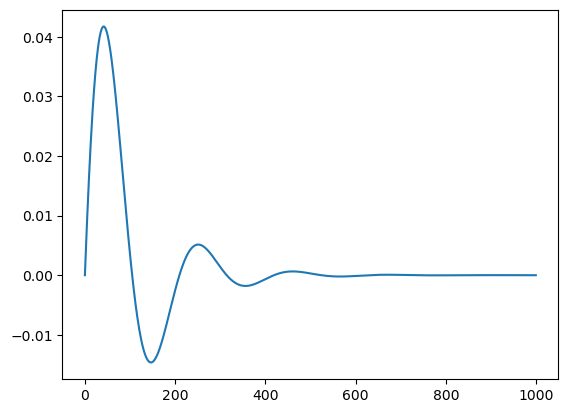

In [60]:
plt.plot(oscillator)

In [61]:
import scipy.stats.qmc as qmc

In [62]:
latent_sampler = qmc.LatinHypercube(d=3)
latent_sample = latent_sampler.random(n=18)

In [63]:
l_bounds = [-2,0,0]
u_bounds = [-0.1, 2,2]
latent = qmc.scale(latent_sample, l_bounds, u_bounds)

In [64]:
theta_sampler = qmc.LatinHypercube(d=1)
theta_sample = theta_sampler.random(n=500)

l_bounds = [0]
u_bounds = [10]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [65]:
y = np.zeros(500)
for i in range(500):
    x=int(theta[i]/0.01)
    y[i]=computeResponse(0.01,10,1,latent[0])[x]

In [66]:
options = np.linspace(0,18)

In [67]:
X=torch.tensor(theta)
y=torch.tensor(y)
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X,
    y,
    test_size=200,
    random_state=seed
)
nt=30
reps = 10
x=np.zeros(nt)
R2=np.zeros(nt)
MSE=np.zeros(nt)
for i in range(nt):
    for k in range(reps):
        # split original dataset in training, validation and testing sets
        X2=X_train_all
        y2=y_train_all
        X_train, X_test2, y_train, y_test2 = train_test_split(
            X2,
            y2,
            train_size=(i+1)*3,
            random_state=seed+i
        )
        x[i]=(i+1)*3
        emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')
        R2[i]+=emulator.R2(X_test,y_test[:,None])/reps
        MSE[i]+=emulator.MSE(X_test,y_test[:,None])/reps

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


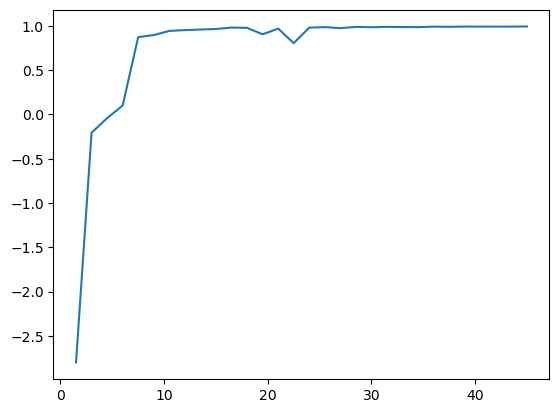

In [68]:
plt.plot(x[:50]/2,R2[:50])

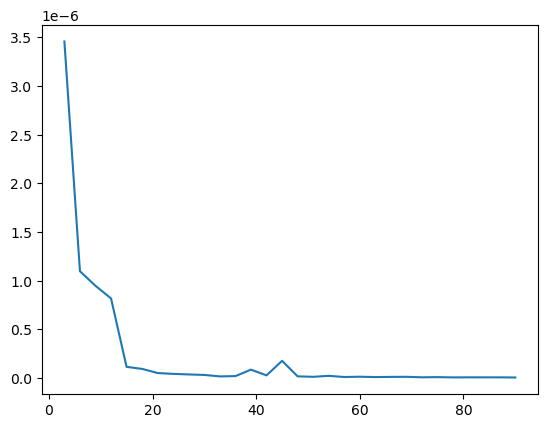

In [69]:
plt.plot(x,MSE)

In [70]:
nsamp=40

In [71]:
theta_sampler = qmc.LatinHypercube(d=1)
theta_sample = theta_sampler.random(n=nsamp)

In [72]:
l_bounds = [0]
u_bounds = [10]
theta = qmc.scale(theta_sample, l_bounds, u_bounds)

In [73]:
int(theta[0]/0.01)

799

In [74]:
y = np.zeros(nsamp)
for i in range(nsamp):
    x=int(theta[i]/0.01)
    y[i]=computeResponse(0.01,10,1,latent[0])[x]
    

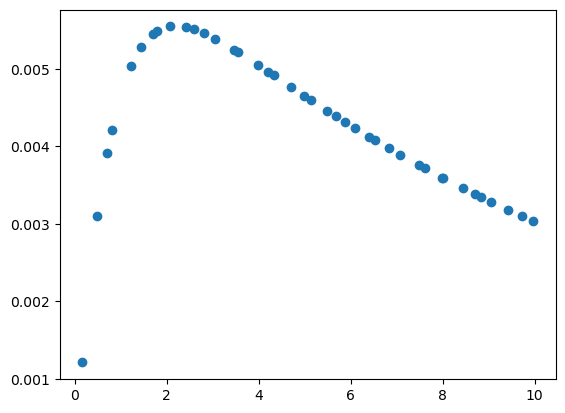

In [75]:
plt.plot(theta,y,'o')

In [76]:
# split original dataset in training, validation and testing sets
X=torch.tensor(theta)
y=torch.tensor(y)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=seed
)

In [77]:
emulator=GPE.ensemble(X_train,y_train[:,None],mean_func='linear')

0


In [78]:
emulator.R2(X_test,y_test[:,None])

tensor([0.9959], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [79]:
latent

array([[-1.11350202,  1.58710549,  0.12870283],
       [-1.8681747 ,  1.86846883,  0.79154562],
       [-0.51461268,  1.77685037,  0.69027379],
       [-0.86001348,  0.37795224,  0.93431245],
       [-1.1640399 ,  0.25987823,  1.43450302],
       [-1.54306282,  0.64926968,  1.27618134],
       [-1.89769027,  0.44842686,  0.43948091],
       [-0.3101533 ,  0.66846655,  1.92588191],
       [-1.048911  ,  1.48005704,  1.87565389],
       [-1.69928547,  1.94163929,  0.01778445],
       [-0.11832863,  1.1204472 ,  0.28859447],
       [-0.52267825,  0.81179436,  1.44551765],
       [-1.60906198,  0.04040192,  1.19872894],
       [-0.68208874,  1.01767702,  1.72820235],
       [-1.3276396 ,  0.12022672,  1.03372241],
       [-1.44270409,  1.36707574,  0.61593938],
       [-0.33870782,  0.95718275,  0.44825647],
       [-0.75606212,  1.30157432,  1.59424353]])

In [80]:
inputs=[]
for i,l in enumerate(latent):
    theta_sampler = qmc.LatinHypercube(d=1)
    theta_sample = theta_sampler.random(n=nsamp)
    l_bounds = [0]
    u_bounds = [10]
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)

In [81]:
oscillator[(inputs[1]/0.01).astype(int)]

array([[-8.27425036e-04],
       [-2.73048818e-05],
       [ 1.48143866e-04],
       [-1.01634474e-02],
       [ 3.78578912e-02],
       [ 9.58624093e-06],
       [-3.07278359e-06],
       [ 4.86118813e-03],
       [ 8.55002284e-04],
       [ 1.71477744e-03],
       [ 5.70532486e-04],
       [ 6.00295713e-04],
       [-1.48960414e-03],
       [ 3.74982406e-03],
       [-1.34089457e-02],
       [-2.12085833e-04],
       [ 7.55081697e-05],
       [-6.54426143e-04],
       [-1.76931974e-03],
       [ 7.69414168e-05],
       [ 3.01313737e-05],
       [-1.44222037e-02],
       [-1.76760023e-04],
       [-2.59788410e-05],
       [ 3.09493002e-06],
       [ 6.15095182e-06],
       [ 9.15236645e-06],
       [-7.37637570e-06],
       [ 4.17051964e-02],
       [ 3.94971610e-04],
       [-7.58733227e-06],
       [ 2.36600594e-02],
       [ 2.41183407e-06],
       [ 4.98417005e-03],
       [ 2.67013556e-06],
       [-5.07115380e-05],
       [-1.77885326e-04],
       [-3.18653573e-06],
       [-4.5

In [82]:
response = computeResponse(0.01,10,1,latent[0])
theta=(inputs[i]/0.01).astype(int)

In [83]:
response[theta]

array([[0.00493142],
       [0.00352915],
       [0.00551129],
       [0.003778  ],
       [0.00510844],
       [0.00429071],
       [0.00555034],
       [0.0030266 ],
       [0.00334531],
       [0.00241457],
       [0.00366568],
       [0.00478476],
       [0.00426142],
       [0.00553939],
       [0.00523368],
       [0.00339182],
       [0.00523436],
       [0.00534383],
       [0.00420737],
       [0.00410706],
       [0.00314104],
       [0.00470988],
       [0.00348077],
       [0.00451965],
       [0.00524104],
       [0.00369743],
       [0.00329374],
       [0.00493943],
       [0.00459283],
       [0.00548684],
       [0.0053952 ],
       [0.00320402],
       [0.00392736],
       [0.00387695],
       [0.0044322 ],
       [0.00367006],
       [0.00498687],
       [0.00541647],
       [0.00034917],
       [0.00406491]])

In [84]:
outputs = []
for i,l in enumerate(latent):
    response = computeResponse(0.01,10,1,l)
    theta=(inputs[i]/0.01).astype(int)
    outputs.append(response[theta])

In [85]:
outputs

[array([[0.00316007],
        [0.00463945],
        [0.00551688],
        [0.00480831],
        [0.00428704],
        [0.00357204],
        [0.00308462],
        [0.00344789],
        [0.0036061 ],
        [0.00257561],
        [0.00331084],
        [0.00451965],
        [0.00376824],
        [0.00395111],
        [0.00342417],
        [0.00135509],
        [0.0040059 ],
        [0.00311404],
        [0.00450785],
        [0.00387361],
        [0.00468634],
        [0.00516193],
        [0.00508901],
        [0.00493539],
        [0.0050342 ],
        [0.0036847 ],
        [0.00324297],
        [0.00426508],
        [0.00442466],
        [0.00516231],
        [0.00554369],
        [0.00344388],
        [0.00542528],
        [0.00552163],
        [0.00411766],
        [0.00531612],
        [0.0053782 ],
        [0.00554762],
        [0.00479663],
        [0.0053501 ]]),
 array([[ 2.46987032e-03],
        [-2.13310611e-05],
        [ 8.46094941e-04],
        [ 3.40546737e-03],
        [ 

In [86]:
R2_mean = np.zeros((1,len(inputs)) )
R2_std = np.zeros((1,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean,std=emulator.R2_sample(X_test,y_test,100)
    R2_mean[:,i]=mean
    R2_std[:,i]=std

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [87]:
y_train.shape

torch.Size([32, 1])

Text(0, 0.5, '$R^2$')

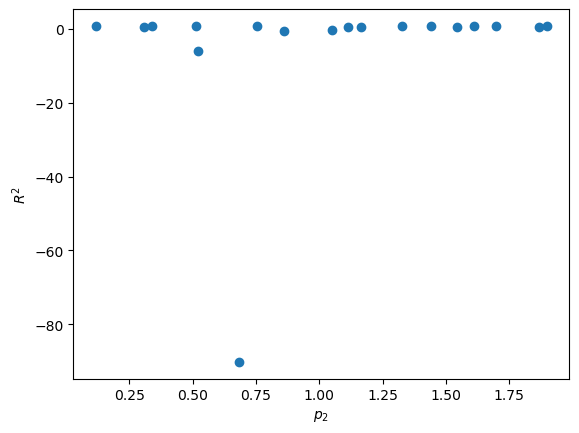

In [88]:
plt.plot(-latent[:,0],R2_mean.T,'o')
#plt.legend(['dif','end','mean'])
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

In [89]:
R2_mean = np.zeros((1,len(inputs)) )
MSE = np.zeros((1,len(inputs))) 
yvar=np.zeros((1,len(inputs))) 
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean=emulator.R2(X_test,y_test)
    R2_mean[:,i]=mean.detach().numpy()
    M=emulator.MSE(X_test,y_test)
    MSE[:,i]=M.detach().numpy()
    yvar[:,i]=y_test.var()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


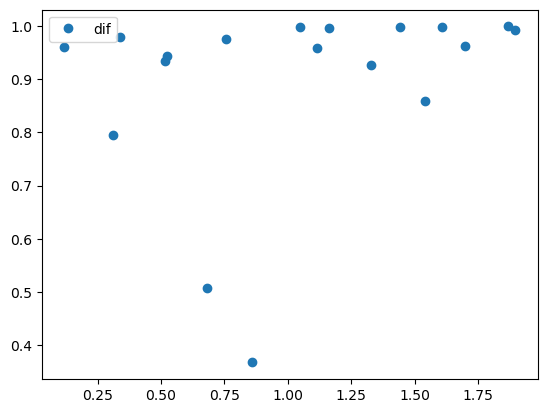

In [90]:
plt.plot(-latent[:,0],R2_mean.T,'o')
plt.legend(['dif','end','mean'])

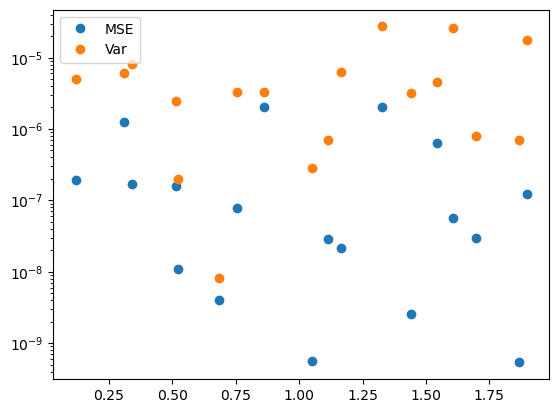

In [91]:
plt.plot(-latent[:,0],MSE.T,'o')
plt.plot(-latent[:,0],yvar.T,'o')
plt.legend(['MSE','Var'])
plt.yscale('log')

In [92]:
R2_mean

array([[0.9596523 , 0.9992429 , 0.93511802, 0.36755049, 0.99661601,
        0.85948348, 0.99312466, 0.79532623, 0.99804974, 0.96280503,
        0.96083802, 0.9434675 , 0.99784952, 0.50805593, 0.92665911,
        0.99919057, 0.97908193, 0.97636974]])

In [93]:
1-MSE.T/y_test.var()

tensor([[0.9914],
        [0.9998],
        [0.9516],
        [0.3756],
        [0.9936],
        [0.8045],
        [0.9629],
        [0.6185],
        [0.9998],
        [0.9910],
        [0.9414],
        [0.9966],
        [0.9830],
        [0.9988],
        [0.3935],
        [0.9992],
        [0.9490],
        [0.9764]], dtype=torch.float64)

In [94]:
large_input = np.array(inputs[0:17]).reshape(17*nsamp,1)

In [95]:
latent[0:17]

array([[-1.11350202,  1.58710549,  0.12870283],
       [-1.8681747 ,  1.86846883,  0.79154562],
       [-0.51461268,  1.77685037,  0.69027379],
       [-0.86001348,  0.37795224,  0.93431245],
       [-1.1640399 ,  0.25987823,  1.43450302],
       [-1.54306282,  0.64926968,  1.27618134],
       [-1.89769027,  0.44842686,  0.43948091],
       [-0.3101533 ,  0.66846655,  1.92588191],
       [-1.048911  ,  1.48005704,  1.87565389],
       [-1.69928547,  1.94163929,  0.01778445],
       [-0.11832863,  1.1204472 ,  0.28859447],
       [-0.52267825,  0.81179436,  1.44551765],
       [-1.60906198,  0.04040192,  1.19872894],
       [-0.68208874,  1.01767702,  1.72820235],
       [-1.3276396 ,  0.12022672,  1.03372241],
       [-1.44270409,  1.36707574,  0.61593938],
       [-0.33870782,  0.95718275,  0.44825647]])

In [96]:
mean=emulator.R2(X_test,y_test)

M=emulator.MSE(X_test,y_test)


In [97]:
modeweights1 = np.repeat(latent[0:17,0],nsamp)

In [98]:
modeweights2= np.repeat(latent[0:17,1],nsamp)

In [99]:
large_input = np.concatenate((large_input,modeweights1[:,None],modeweights2[:,None]),axis=1)

In [100]:
large_output = np.array(outputs[0:17]).reshape(17*nsamp,1)

In [101]:
leftout_input = np.concatenate((inputs[17],np.repeat(latent[17,0],nsamp)[:,None],np.repeat(latent[17,1],nsamp)[:,None]),axis=1)

In [102]:
large_input.shape

(680, 3)

In [103]:
# split original dataset in training, validation and testing sets
X=torch.tensor(large_input)
y=torch.tensor(large_output)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=300,
    random_state=seed
)

emulator=GPE.ensemble(X_train,y_train,mean_func='linear')

emulator.R2(X_test,y_test)

0


tensor([0.9462], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [104]:
emulator.R2(torch.tensor(leftout_input),torch.tensor(outputs[17]))

tensor([0.8020], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [105]:
modeweights.shape

NameError: name 'modeweights' is not defined

In [106]:
780/nsamp

19.5

In [107]:
340/nsamp

8.5

In [108]:
latent.shape

(18, 3)

In [109]:
R2_in = torch.zeros((18,1))
R2_out = torch.zeros((18,1))
MSE_out=torch.zeros((18,1))
for i in range(18):
    
    
    
    large_input = np.array(inputs[0:i]+inputs[i+1:18]).reshape(17*nsamp,1)

    latent2=latent.copy()
    latent2=np.delete(latent2,i,axis=0)

    modeweights = np.repeat(latent2,nsamp,axis=0)

    large_input = np.concatenate((large_input,modeweights),axis=1)

    large_output = np.array(outputs[0:i]+outputs[i+1:18]).reshape(17*nsamp,1)
    
    leftout_input=torch.tensor(np.concatenate((inputs[i],np.repeat(latent[[i]],nsamp,axis=0)),axis=1))
    leftout_output=torch.tensor(outputs[i])
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(large_input)
    y=torch.tensor(large_output)
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        train_size=300,
        random_state=seed
    )

    emulator=GPE.ensemble(X_train,y_train,mean_func='linear',training_iter=1000)

    R2_in[i]=emulator.R2(X_test,y_test)

    R2_out[i]=emulator.R2(leftout_input,leftout_output)
    MSE_out[i]=emulator.MSE(leftout_input,leftout_output)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


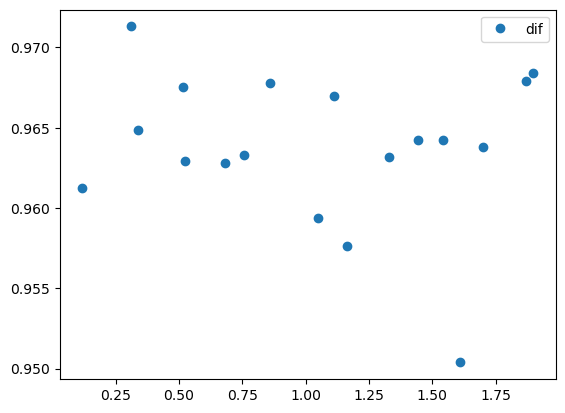

In [110]:
plt.plot(-latent[:,0],R2_in.detach().numpy(),'o')
plt.legend(['dif','end','mean'])

Text(0, 0.5, '$R^2$')

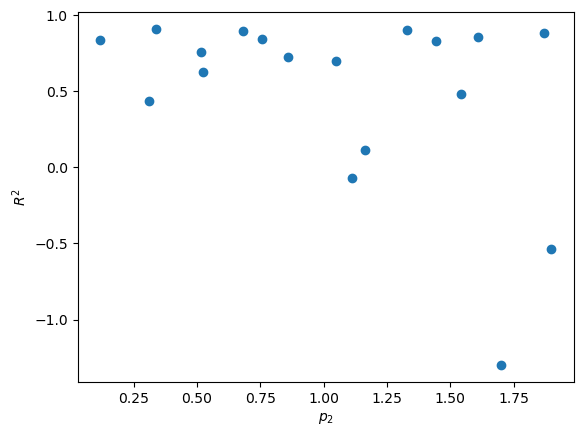

In [111]:
plt.plot(-latent[:,0],R2_out.detach().numpy(),'o')
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

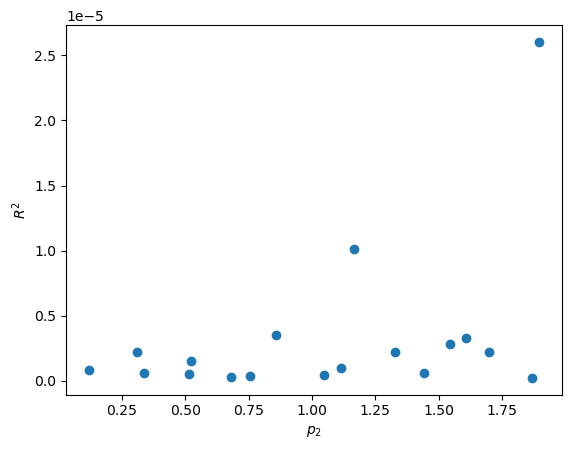

In [112]:
plt.plot(-latent[:,0],MSE_out.detach().numpy(),'o')
plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

In [113]:
inputs.copy()

[array([[9.49548098],
        [5.02280821],
        [2.55238895],
        [1.06274933],
        [5.9516294 ],
        [8.07469455],
        [9.77593583],
        [8.48410617],
        [7.96457818],
        [0.37884123],
        [8.95540583],
        [5.33965453],
        [7.45266011],
        [6.90976844],
        [8.56441786],
        [0.17686344],
        [6.74774036],
        [9.660661  ],
        [0.91748697],
        [7.13544277],
        [4.90063246],
        [1.31827113],
        [3.8864498 ],
        [4.27313721],
        [4.02253207],
        [7.71001096],
        [9.19300499],
        [6.01388916],
        [5.58664066],
        [3.69712129],
        [2.36160857],
        [0.56758614],
        [2.93839286],
        [1.90518043],
        [6.42356334],
        [3.27762921],
        [1.56374601],
        [2.07295864],
        [4.62814805],
        [3.17288155]]),
 array([[3.25871143],
        [7.73357339],
        [5.11495631],
        [1.23489099],
        [0.56443132],
        

In [114]:
X_train

tensor([[ 4.9772, -1.5431,  0.6493,  1.2762],
        [ 6.7939, -1.6091,  0.0404,  1.1987],
        [ 4.8663, -0.8600,  0.3780,  0.9343],
        ...,
        [ 6.6665, -0.6821,  1.0177,  1.7282],
        [ 7.3974, -1.1640,  0.2599,  1.4345],
        [ 1.2341, -1.1640,  0.2599,  1.4345]], dtype=torch.float64)

In [115]:
def proxy(a,y_train,m0):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean().detach().numpy()
    return res

In [116]:
import scipy

In [117]:
m0 = emulator_0.predict(X_train)

NameError: name 'emulator_0' is not defined

In [ ]:
proxy(1.468e-01,y_train,m0)

In [ ]:
result = scipy.optimize.minimize(proxy, 1, args=(y_train,m0), method='Nelder-Mead', tol=1e-8)


In [ ]:
result

In [118]:
t_size = 30
reps = 1
MSE = np.zeros((18,17,1))
R2 = np.zeros((18,17,1))
for i in range(18):

    X0 = torch.tensor(inputs[i])
    Y0 = torch.tensor(outputs[i])
    emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)
    
    inputs2 = inputs.copy()
    inputs2.pop(i)
    outputs2 = outputs.copy()
    outputs2.pop(i)
    
    for j in (range(17)):
        inputData_1 = inputs2[j]
        outputData_1 = outputs2[j]

        X1 = torch.tensor(inputData_1)
        Y1 = torch.tensor(outputData_1)
        # split original dataset in training, validation and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X1,
            Y1,
            test_size=0.1,
            random_state=seed
        )
        for k in range(reps):
            a=np.random.choice(range(X_train.shape[0]),t_size,replace=False)
            m0 = emulator_0.predict(X_train[a,:])
            y_adjust = torch.tensor(y_train[a] - m0)
            delta_1 = GPE.ensemble(X_train[a,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps



0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/984007682.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[a] - m0)


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/984007682.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,j,:] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/984007682.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,j,:] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [119]:
latent[:,0]

array([-1.11350202, -1.8681747 , -0.51461268, -0.86001348, -1.1640399 ,
       -1.54306282, -1.89769027, -0.3101533 , -1.048911  , -1.69928547,
       -0.11832863, -0.52267825, -1.60906198, -0.68208874, -1.3276396 ,
       -1.44270409, -0.33870782, -0.75606212])

In [120]:
R2.mean(axis=1)[:,0]

array([-0.06312019,  0.30129148,  0.68883053, -1.43721729, -0.07005799,
        0.12834636, -1.38096716,  0.87030832,  0.83853598, -0.03626256,
        0.49472844,  0.86564423, -1.77517702,  0.83321895, -1.61099362,
        0.38897787,  0.32249309,  0.89085844])

In [121]:
R2.std(axis=1)

array([[2.67930857],
       [1.41611927],
       [0.98379724],
       [8.29616945],
       [2.39017711],
       [2.04171587],
       [5.89012883],
       [0.23579254],
       [0.41757752],
       [2.1449891 ],
       [1.13335822],
       [0.30771726],
       [6.61104243],
       [0.42750562],
       [5.90817262],
       [1.26819228],
       [1.45322178],
       [0.31678629]])

In [122]:
R2

array([[[ 9.95272398e-01],
        [ 9.95333976e-01],
        [-2.09889630e+00],
        [ 9.97659672e-01],
        [ 8.21037873e-01],
        [ 9.83672472e-01],
        [ 9.44032963e-01],
        [ 9.20775230e-01],
        [ 9.63417670e-01],
        [ 8.10435263e-01],
        [-9.98004847e+00],
        [ 9.97754688e-01],
        [-2.31724394e+00],
        [ 9.68170004e-01],
        [ 9.99573158e-01],
        [ 9.55562284e-01],
        [ 9.70447746e-01]],

       [[ 9.35326524e-01],
        [ 9.94464493e-01],
        [-3.24424959e+00],
        [ 9.93900173e-01],
        [ 6.15220827e-01],
        [ 9.83475833e-01],
        [ 9.91610445e-01],
        [ 9.87663467e-01],
        [ 9.76385586e-01],
        [ 9.57223532e-01],
        [-2.09188853e+00],
        [ 9.98480908e-01],
        [-2.82813454e+00],
        [ 9.32370285e-01],
        [ 9.99719723e-01],
        [ 9.62204915e-01],
        [ 9.58181176e-01]],

       [[ 9.58267762e-01],
        [ 9.97980706e-01],
        [-3.22364434e+00

Text(0, 0.5, '$R^2$')

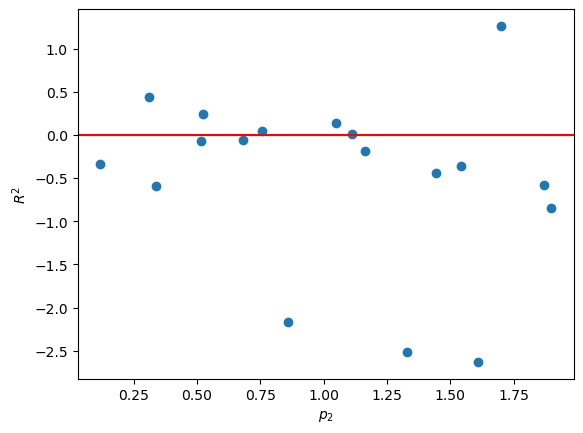

In [123]:
fig, ax = plt.subplots()


ax.scatter(-latent[:,0],R2.mean(axis=1)[:,0]-R2_out.detach().numpy()[:,0])
plt.axhline(y=0, color='r', linestyle='-')
#ax.scatter(latent[9:,0],R2_out.detach().numpy()[9:,2])

#ax.scatter(latent,R2.mean(axis=1)[:,1])
#ax.scatter(latent,R2_out.detach().numpy()[:,1])

#ax.scatter(latent,R2.mean(axis=1)[:,2])
#ax.scatter(latent,R2_out.detach().numpy()[:,2])

#plt.errorbar(latent,R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])


#ax.scatter(latent,R2.mean(axis=1)[:,1])
#plt.errorbar(latent,R2.mean(axis=1)[:,1],fmt='o',yerr=R2.std(axis=1)[:,1])


#ax.scatter(latent,R2.mean(axis=1)[:,2])
#plt.errorbar(latent,R2.mean(axis=1)[:,2],fmt='o',yerr=R2.std(axis=1)[:,2])


plt.xlabel('$p_2$')
plt.ylabel('$R^2$')

Text(0, 0.5, '$R^2$')

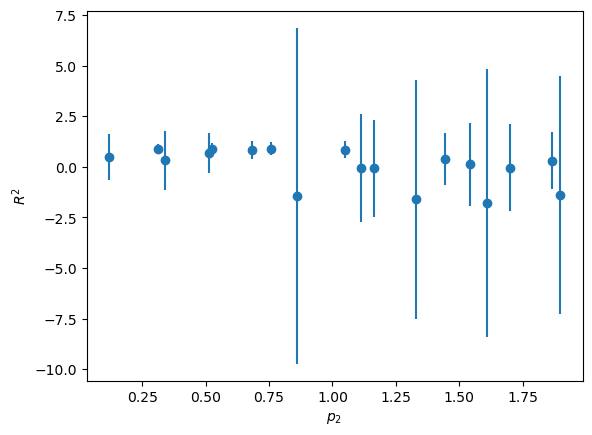

In [124]:

ax.scatter(-latent[:,0],R2.mean(axis=1)[:,0])
plt.errorbar(-latent[:,0],R2.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])



plt.xlabel('$p_2$')
plt.ylabel('$R^2$')
#plt.yscale('log')

In [147]:

ax.scatter(-latent[:,0],MSE.mean(axis=1)[:,0])
#plt.errorbar(latent[:,0],MSE.mean(axis=1)[:,0],fmt='o',yerr=R2.std(axis=1)[:,0])



plt.xlabel('$p_2$')
plt.ylabel('$R^2$')
#plt.yscale('log')

ValueError: x and y must be the same size

In [126]:
X0 = torch.tensor(inputs[0])
Y0 = torch.tensor(outputs[0])
emulator_0 = GPE.ensemble(X0,Y0,mean_func="linear",training_iter=500)

0


In [127]:
X0.shape[0]*0.05

2.0

In [128]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE = np.zeros((n,m,1))
R2 = np.zeros((n,m,1))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            y_adjust = torch.tensor(y_train[b] - m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/3172062991.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - m0)


0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/3172062991.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE[i,k] += np.sqrt(((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/3172062991.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R2[i,k] += (1-((emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


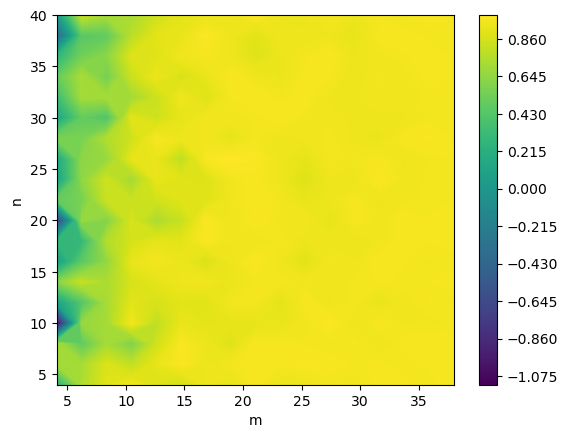

In [129]:
x = np.linspace(2,38,18)

x

y = np.linspace(2,40,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2[level:,level:,0],origin='lower',levels=500)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()

In [130]:
def proxy(a,y_train,m0,output):
    a=torch.tensor(a)
    res = ((a*m0-y_train)**2).mean(axis=1).detach().numpy()
    return res[output]

In [131]:
import scipy

In [132]:
#b=np.random.choice(range(X_train.shape[0]),18,replace=False)
p = int(X0.shape[0]*0.05)
n = int(X0.shape[0]/p)
m = 18
MSE_a = np.zeros((n,m,1))
R2_a = np.zeros((n,m,1))
reps = 5
for i in range(n):
    for k in range(m):
        for j in range(reps):
            b=np.random.choice(range(X_train.shape[0]),(k+1)*p,replace=False)
            a=np.random.choice(range(X0.shape[0]),(i+1)*p,replace=False)
            emulator_0 = GPE.ensemble(X0[a,:],Y0[a,:],mean_func="linear",training_iter=500)
            m0 = emulator_0.predict(X_train[b,:])
            a_d=np.zeros(y_train.shape[1])
            for l in range(y_train.shape[1]):
                result = scipy.optimize.minimize(proxy, 1, args=(y_train[b,:],m0,l), method='Nelder-Mead', tol=1e-8)
                print(result.x)
                a_d[l]=result.x

            a_d=torch.tensor(a_d)
            print(a_d)
            
            y_adjust = torch.tensor(y_train[b] - a_d*m0)
            delta_1 = GPE.ensemble(X_train[b,:],y_adjust,mean_func="linear",training_iter=500)
            MSE_a[i,k,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
            R2_a[i,k,:] += (1-((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0)/torch.tensor(y_test.var(axis=0))).detach().numpy()/reps

0
[1.24066154]
tensor([1.2407], dtype=torch.float64)
0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_adjust = torch.tensor(y_train[b] - a_d*m0)
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_a[i,k,:] += np.sqrt(((a_d*emulator_0.predict(X_test)+delta_1.predict(X_test)-torch.tensor(y_test))**2).mean(axis=0).detach().numpy())/reps
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_15665/1148931251.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

0
[0.29930915]
tensor([0.2993], dtype=torch.float64)
0
0
[0.30208411]
tensor([0.3021], dtype=torch.float64)
0
0
[0.03561517]
tensor([0.0356], dtype=torch.float64)
0
0
[0.10378384]
tensor([0.1038], dtype=torch.float64)
0
0
[0.32773211]
tensor([0.3277], dtype=torch.float64)
0
0
[0.31489922]
tensor([0.3149], dtype=torch.float64)
0
0
[1.0540279]
tensor([1.0540], dtype=torch.float64)
0
0
[3.06547928]
tensor([3.0655], dtype=torch.float64)
0
0
[0.05704001]
tensor([0.0570], dtype=torch.float64)
0
0
[0.29839577]
tensor([0.2984], dtype=torch.float64)
0
0
[0.64825125]
tensor([0.6483], dtype=torch.float64)
0
0
[0.05958042]
tensor([0.0596], dtype=torch.float64)
0
0
[0.21936197]
tensor([0.2194], dtype=torch.float64)
0
0
[0.62076582]
tensor([0.6208], dtype=torch.float64)
0
0
[0.30919249]
tensor([0.3092], dtype=torch.float64)
0
0
[0.45918038]
tensor([0.4592], dtype=torch.float64)
0
0
[1.1192014]
tensor([1.1192], dtype=torch.float64)
0
0
[0.67379978]
tensor([0.6738], dtype=torch.float64)
0
0
[0.1183103

0
[0.17983769]
tensor([0.1798], dtype=torch.float64)
0
0
[0.03315623]
tensor([0.0332], dtype=torch.float64)
0
0
[0.69606571]
tensor([0.6961], dtype=torch.float64)
0
0
[1.34031129]
tensor([1.3403], dtype=torch.float64)
0
0
[1.11031591]
tensor([1.1103], dtype=torch.float64)
0
0
[1.24382904]
tensor([1.2438], dtype=torch.float64)
0
0
[1.54938691]
tensor([1.5494], dtype=torch.float64)
0
0
[0.27867917]
tensor([0.2787], dtype=torch.float64)
0
0
[1.33984476]
tensor([1.3398], dtype=torch.float64)
0
0
[0.00814981]
tensor([0.0081], dtype=torch.float64)
0
0
[0.01219228]
tensor([0.0122], dtype=torch.float64)
0
0
[0.10392925]
tensor([0.1039], dtype=torch.float64)
0
0
[0.12562092]
tensor([0.1256], dtype=torch.float64)
0
0
[0.32258839]
tensor([0.3226], dtype=torch.float64)
0
0
[0.03423767]
tensor([0.0342], dtype=torch.float64)
0
0
[0.82643521]
tensor([0.8264], dtype=torch.float64)
0
0
[1.34148853]
tensor([1.3415], dtype=torch.float64)
0
0
[0.71027526]
tensor([0.7103], dtype=torch.float64)
0
0
[0.08385

0
[0.08492904]
tensor([0.0849], dtype=torch.float64)
0
0
[0.01875169]
tensor([0.0188], dtype=torch.float64)
0
0
[1.68181443]
tensor([1.6818], dtype=torch.float64)
0
0
[0.08658729]
tensor([0.0866], dtype=torch.float64)
0
0
[1.00300329]
tensor([1.0030], dtype=torch.float64)
0
0
[0.05477945]
tensor([0.0548], dtype=torch.float64)
0
0
[0.18831741]
tensor([0.1883], dtype=torch.float64)
0
0
[1.05867622]
tensor([1.0587], dtype=torch.float64)
0
0
[0.15413042]
tensor([0.1541], dtype=torch.float64)
0
0
[1.10744681]
tensor([1.1074], dtype=torch.float64)
0
0
[1.4335888]
tensor([1.4336], dtype=torch.float64)
0
0
[0.07638537]
tensor([0.0764], dtype=torch.float64)
0
0
[0.05272739]
tensor([0.0527], dtype=torch.float64)
0
0
[0.1275948]
tensor([0.1276], dtype=torch.float64)
0
0
[0.01212005]
tensor([0.0121], dtype=torch.float64)
0
0
[0.04931388]
tensor([0.0493], dtype=torch.float64)
0
0
[1.37239449]
tensor([1.3724], dtype=torch.float64)
0
0
[0.52633104]
tensor([0.5263], dtype=torch.float64)
0
0
[0.0667315

0
[0.26947568]
tensor([0.2695], dtype=torch.float64)
0
0
[0.83261613]
tensor([0.8326], dtype=torch.float64)
0
0
[1.72653139]
tensor([1.7265], dtype=torch.float64)
0
0
[0.18686861]
tensor([0.1869], dtype=torch.float64)
0
0
[0.25503113]
tensor([0.2550], dtype=torch.float64)
0
0
[0.06724038]
tensor([0.0672], dtype=torch.float64)
0
0
[0.03386637]
tensor([0.0339], dtype=torch.float64)
0
0
[0.38054606]
tensor([0.3805], dtype=torch.float64)
0
0
[0.16989834]
tensor([0.1699], dtype=torch.float64)
0
0
[0.02000909]
tensor([0.0200], dtype=torch.float64)
0
0
[0.05649999]
tensor([0.0565], dtype=torch.float64)
0
0
[0.0487396]
tensor([0.0487], dtype=torch.float64)
0
0
[0.89738665]
tensor([0.8974], dtype=torch.float64)
0
0
[0.15278203]
tensor([0.1528], dtype=torch.float64)
0
0
[0.10419539]
tensor([0.1042], dtype=torch.float64)
0
0
[0.01459722]
tensor([0.0146], dtype=torch.float64)
0
0
[0.04112788]
tensor([0.0411], dtype=torch.float64)
0
0
[0.30240745]
tensor([0.3024], dtype=torch.float64)
0
0
[0.024877

0
[0.39108801]
tensor([0.3911], dtype=torch.float64)
0
0
[0.22615176]
tensor([0.2262], dtype=torch.float64)
0
0
[0.31461067]
tensor([0.3146], dtype=torch.float64)
0
0
[0.25991129]
tensor([0.2599], dtype=torch.float64)
0
0
[0.49973912]
tensor([0.4997], dtype=torch.float64)
0
0
[0.16930116]
tensor([0.1693], dtype=torch.float64)
0
0
[0.75853246]
tensor([0.7585], dtype=torch.float64)
0
0
[2.31421866]
tensor([2.3142], dtype=torch.float64)
0
0
[0.02027993]
tensor([0.0203], dtype=torch.float64)
0
0
[0.07646962]
tensor([0.0765], dtype=torch.float64)
0
0
[0.03494858]
tensor([0.0349], dtype=torch.float64)
0
0
[0.02432687]
tensor([0.0243], dtype=torch.float64)
0
0
[0.06676378]
tensor([0.0668], dtype=torch.float64)
0
0
[0.07673813]
tensor([0.0767], dtype=torch.float64)
0
0
[0.01720967]
tensor([0.0172], dtype=torch.float64)
0
0
[0.12541186]
tensor([0.1254], dtype=torch.float64)
0
0
[0.80446972]
tensor([0.8045], dtype=torch.float64)
0
0
[0.39599438]
tensor([0.3960], dtype=torch.float64)
0
0
[0.03408

0
[0.18362992]
tensor([0.1836], dtype=torch.float64)
0
0
[0.22713291]
tensor([0.2271], dtype=torch.float64)
0
0
[0.25402626]
tensor([0.2540], dtype=torch.float64)
0
0
[0.04251914]
tensor([0.0425], dtype=torch.float64)
0
0
[0.03492318]
tensor([0.0349], dtype=torch.float64)
0
0
[0.01650333]
tensor([0.0165], dtype=torch.float64)
0
0
[0.97273878]
tensor([0.9727], dtype=torch.float64)
0
0
[0.67023239]
tensor([0.6702], dtype=torch.float64)
0
0
[0.62134095]
tensor([0.6213], dtype=torch.float64)
0
0
[0.26923084]
tensor([0.2692], dtype=torch.float64)
0
0
[0.01647781]
tensor([0.0165], dtype=torch.float64)
0
0
[0.04296893]
tensor([0.0430], dtype=torch.float64)
0
0
[0.64325829]
tensor([0.6433], dtype=torch.float64)
0
0
[0.25558187]
tensor([0.2556], dtype=torch.float64)
0
0
[0.39875013]
tensor([0.3988], dtype=torch.float64)
0
0
[0.04240785]
tensor([0.0424], dtype=torch.float64)
0
0
[0.04913445]
tensor([0.0491], dtype=torch.float64)
0
0
[0.07663812]
tensor([0.0766], dtype=torch.float64)
0
0
[0.88642

[0.034209]
tensor([0.0342], dtype=torch.float64)
0
0
[0.61596652]
tensor([0.6160], dtype=torch.float64)
0
0
[0.1860173]
tensor([0.1860], dtype=torch.float64)
0
0
[1.9049467]
tensor([1.9049], dtype=torch.float64)
0
0
[0.22752687]
tensor([0.2275], dtype=torch.float64)
0
0
[0.10299227]
tensor([0.1030], dtype=torch.float64)
0
0
[0.30602409]
tensor([0.3060], dtype=torch.float64)
0
0
[0.01762063]
tensor([0.0176], dtype=torch.float64)
0
0
[0.66067829]
tensor([0.6607], dtype=torch.float64)
0
0
[0.46700424]
tensor([0.4670], dtype=torch.float64)
0
0
[0.27117557]
tensor([0.2712], dtype=torch.float64)
0
0
[0.3872237]
tensor([0.3872], dtype=torch.float64)
0
0
[0.18174663]
tensor([0.1817], dtype=torch.float64)
0
0
[0.01758458]
tensor([0.0176], dtype=torch.float64)
0
0
[0.06673566]
tensor([0.0667], dtype=torch.float64)
0
0
[0.03430557]
tensor([0.0343], dtype=torch.float64)
0
0
[0.08670424]
tensor([0.0867], dtype=torch.float64)
0
0
[0.22975293]
tensor([0.2298], dtype=torch.float64)
0
0
[0.83048171]
te

0
[0.03406461]
tensor([0.0341], dtype=torch.float64)
0
0
[0.03420824]
tensor([0.0342], dtype=torch.float64)
0
0
[0.05688592]
tensor([0.0569], dtype=torch.float64)
0
0
[0.46584134]
tensor([0.4658], dtype=torch.float64)
0
0
[0.18121147]
tensor([0.1812], dtype=torch.float64)
0
0
[1.76719209]
tensor([1.7672], dtype=torch.float64)
0
0
[0.25417979]
tensor([0.2542], dtype=torch.float64)
0
0
[0.38541193]
tensor([0.3854], dtype=torch.float64)
0
0
[0.057152]
tensor([0.0572], dtype=torch.float64)
0
0
[0.81376492]
tensor([0.8138], dtype=torch.float64)
0
0
[0.12582309]
tensor([0.1258], dtype=torch.float64)
0
0
[1.4508149]
tensor([1.4508], dtype=torch.float64)
0
0
[1.57460965]
tensor([1.5746], dtype=torch.float64)
0
0
[2.16156721]
tensor([2.1616], dtype=torch.float64)
0
0
[1.90283642]
tensor([1.9028], dtype=torch.float64)
0
0
[0.98916178]
tensor([0.9892], dtype=torch.float64)
0
0
[0.03518383]
tensor([0.0352], dtype=torch.float64)
0
0
[0.85401608]
tensor([0.8540], dtype=torch.float64)
0
0
[0.1825431]

0
[1.41986699]
tensor([1.4199], dtype=torch.float64)
0
0
[0.01784106]
tensor([0.0178], dtype=torch.float64)
0
0
[0.16705001]
tensor([0.1671], dtype=torch.float64)
0
0
[0.0250229]
tensor([0.0250], dtype=torch.float64)
0
0
[1.99042932]
tensor([1.9904], dtype=torch.float64)
0
0
[0.06696094]
tensor([0.0670], dtype=torch.float64)
0
0
[0.0572161]
tensor([0.0572], dtype=torch.float64)
0
0
[1.77983817]
tensor([1.7798], dtype=torch.float64)
0
0
[0.01782315]
tensor([0.0178], dtype=torch.float64)
0
0
[0.05731792]
tensor([0.0573], dtype=torch.float64)
0
0
[2.44558033]
tensor([2.4456], dtype=torch.float64)
0
0
[0.18113545]
tensor([0.1811], dtype=torch.float64)
0
0
[0.1666684]
tensor([0.1667], dtype=torch.float64)
0
0
[0.82580905]
tensor([0.8258], dtype=torch.float64)
0
0
[0.10329617]
tensor([0.1033], dtype=torch.float64)
0
0
[0.0570741]
tensor([0.0571], dtype=torch.float64)
0
0
[0.0342142]
tensor([0.0342], dtype=torch.float64)
0
0
[0.01745018]
tensor([0.0175], dtype=torch.float64)
0
0
[0.05550885]


0
[1.38797032]
tensor([1.3880], dtype=torch.float64)
0
0
[0.03412233]
tensor([0.0341], dtype=torch.float64)
0
0
[0.04215953]
tensor([0.0422], dtype=torch.float64)
0
0
[0.02510586]
tensor([0.0251], dtype=torch.float64)
0
0
[1.29517483]
tensor([1.2952], dtype=torch.float64)
0
0
[0.62190251]
tensor([0.6219], dtype=torch.float64)
0
0
[0.02046346]
tensor([0.0205], dtype=torch.float64)
0
0
[0.02047334]
tensor([0.0205], dtype=torch.float64)
0
0
[0.01653885]
tensor([0.0165], dtype=torch.float64)
0
0
[0.14978365]
tensor([0.1498], dtype=torch.float64)
0
0
[0.83188171]
tensor([0.8319], dtype=torch.float64)
0
0
[0.25465404]
tensor([0.2547], dtype=torch.float64)
0
0
[0.82380648]
tensor([0.8238], dtype=torch.float64)
0
0
[0.03416311]
tensor([0.0342], dtype=torch.float64)
0
0
[0.30338474]
tensor([0.3034], dtype=torch.float64)
0
0
[0.18377892]
tensor([0.1838], dtype=torch.float64)
0
0
[0.03408383]
tensor([0.0341], dtype=torch.float64)
0
0
[0.01782452]
tensor([0.0178], dtype=torch.float64)
0
0
[0.04893

0
[0.64917664]
tensor([0.6492], dtype=torch.float64)
0
0
[0.94938021]
tensor([0.9494], dtype=torch.float64)
0
0
[1.15856876]
tensor([1.1586], dtype=torch.float64)
0
0
[0.05721253]
tensor([0.0572], dtype=torch.float64)
0
0
[0.01649602]
tensor([0.0165], dtype=torch.float64)
0
0
[0.61779711]
tensor([0.6178], dtype=torch.float64)
0
0
[0.04228938]
tensor([0.0423], dtype=torch.float64)
0
0
[0.08621185]
tensor([0.0862], dtype=torch.float64)
0
0
[0.18105989]
tensor([0.1811], dtype=torch.float64)
0
0
[0.25535185]
tensor([0.2554], dtype=torch.float64)
0
0
[0.18085378]
tensor([0.1809], dtype=torch.float64)
0
0
[0.26974159]
tensor([0.2697], dtype=torch.float64)
0
0
[0.03419309]
tensor([0.0342], dtype=torch.float64)
0
0
[1.22398612]
tensor([1.2240], dtype=torch.float64)
0
0
[0.30314141]
tensor([0.3031], dtype=torch.float64)
0
0
[0.18125537]
tensor([0.1813], dtype=torch.float64)
0
0
[2.37214391]
tensor([2.3721], dtype=torch.float64)
0
0
[0.26853358]
tensor([0.2685], dtype=torch.float64)
0
0
[0.04226

0
[0.22717523]
tensor([0.2272], dtype=torch.float64)
0
0
[1.38003756]
tensor([1.3800], dtype=torch.float64)
0
0
[0.04217494]
tensor([0.0422], dtype=torch.float64)
0
0
[0.12572087]
tensor([0.1257], dtype=torch.float64)
0
0
[0.04886842]
tensor([0.0489], dtype=torch.float64)
0
0
[0.46623153]
tensor([0.4662], dtype=torch.float64)
0
0
[0.03407269]
tensor([0.0341], dtype=torch.float64)
0
0
[0.0768836]
tensor([0.0769], dtype=torch.float64)
0
0
[0.81436517]
tensor([0.8144], dtype=torch.float64)
0
0
[1.22267411]
tensor([1.2227], dtype=torch.float64)
0
0
[0.12565065]
tensor([0.1257], dtype=torch.float64)
0
0
[0.03413296]
tensor([0.0341], dtype=torch.float64)
0
0
[1.23013688]
tensor([1.2301], dtype=torch.float64)
0
0
[0.25408611]
tensor([0.2541], dtype=torch.float64)
0
0
[0.01653039]
tensor([0.0165], dtype=torch.float64)
0
0
[0.05716589]
tensor([0.0572], dtype=torch.float64)
0
0
[0.06691501]
tensor([0.0669], dtype=torch.float64)
0
0
[0.03489916]
tensor([0.0349], dtype=torch.float64)
0
0
[0.815253

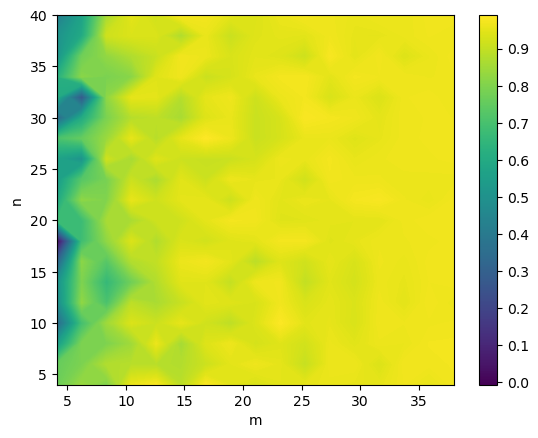

In [134]:
x = np.linspace(2,38,18)

x

y = np.linspace(2,40,20)

y

xx,yy=np.meshgrid(x,y)

xx[1:,1:].shape

level = 1

plt.contourf(xx[level:,level:],yy[level:,level:],R2_a[level:,level:,0],origin='lower',levels=500)
plt.ylabel('n')
plt.xlabel('m')
plt.colorbar()